In [1]:
import pandas as pd

In [14]:
sims_df = pd.read_csv('export.csv')
sims_df = sims_df.loc[sims_df['Text1'].str.contains(':') ^ sims_df['Text2'].str.contains(':')]
mask = sims_df['Text1'].str.contains(':')
sims_df['Text1'].loc[mask],sims_df['Text2'].loc[mask] = sims_df['Text2'].loc[mask],sims_df['Text1'].loc[mask]
sims_df = sims_df.set_index(['Text1','Text2'])
idx = sims_df.index.drop_duplicates(keep = False)
sims_df = sims_df.loc[idx]
sims_df

,,similarity
Text1,Text2,
"""14.pdf""","""d1:Pain_Beliefs.txt""",0.769231
"""20.pdf""","""d1:Psychological_Attributes.txt""",0.750000
"""49.pdf""","""d1:Psychological_Attributes.txt""",0.750000
"""7.pdf""","""d1:Psychological_Attributes.txt""",0.750000
"""21.pdf""","""d1:Pain_Beliefs.txt""",0.692308
...,...,...
"""40.pdf""","""d5:Demographics.txt""",0.333333
"""43.pdf""","""d5:Demographics.txt""",0.333333
"""49.pdf""","""d5:Demographics.txt""",0.333333


In [27]:
import networkx as nx

import pygraphviz

G = nx.Graph()
for ix in sims_df.index:
    G.add_edge(ix[0],ix[1],weight=1-sims_df.loc[ix,'similarity'])

In [31]:
from IPython.display import Image

def draw(A):
    A.write_png("graph.png")
    return Image(A.draw(format='png', prog='dot'))

In [50]:
color_legend = {"d1:":'#D81B60',"d2:":'#1E88E5',"d3:":'#FFC107',"d4:":'#94BBC7',"d5:":'#004D40',"d6:":'#2A465F',"Paper":'#90418E'}
color_map = []
for node in G:
    added = False
    for key in color_legend.keys():
        if key in node:
            color_map.append(color_legend[key])
            added = True
    if not added:
        color_map.append(color_legend['Paper'])
#nx.draw(G, node_color=color_map, with_labels=True)

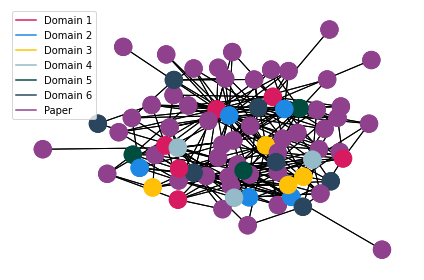

In [60]:
import matplotlib.pyplot as plt

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in color_legend.keys():
    lab = label.replace("d","Domain ").replace(":","")
    ax.plot([0],[0],color=color_legend[label],label=lab)

# Just fixed the color map
#nx.draw_networkx(G,pos, cmap = jet, vmin=0, vmax= max(values),node_color=values,with_labels=True,ax=ax)
pos = nx.spring_layout(G)
a=nx.draw(G, pos=pos, node_color=color_map) #('graph.png')
nx.draw(G, pos=pos, node_color=color_map)  # Draw the original graph

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend()

f.tight_layout()
plt.savefig('similarity_graph.png')
plt.show()


In [57]:
import numpy as np
names = set(sims_df['Text1'].unique())
A = sims_df.set_index(['Text1','Text2'])['similarity'].unstack()
A = A.reindex(index=names,columns=names)
for i in range(len(A)):
    for j in range(len(A)):
        if i == j:
            A.iloc[i,j] = 1.
        elif np.isnan(A.iloc[i,j]) and np.isnan(A.iloc[j,i]):
            A.iloc[i,j] = 0
        elif np.isnan(A.iloc[i,j]):
            A.iloc[i,j] = A.iloc[j,i]
        elif np.isnan(A.iloc[j,i]):
            A.iloc[j,i] = A.iloc[i,j]
A

KeyError: 'Text1'

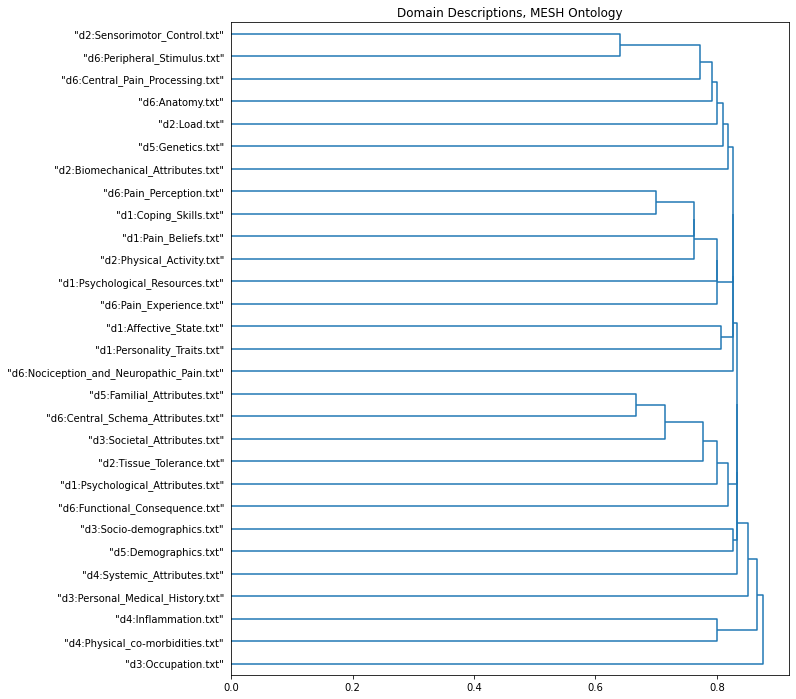

In [62]:
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt

plt.figure(figsize=(10,12))
dists = squareform(1-A)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, orientation="right",labels=A.columns)
plt.title("Domain Descriptions, MESH Ontology")
plt.show()

In [54]:
domains = ["d1","d2","d3","d4","d5","d6"]

In [89]:
dfs = []
for domain in domains:
    d1_embeddings_df = pd.read_csv(f'../../{domain}_descriptions.embeddings/embeddings.csv',header=None,skiprows=1)
    d1_embeddings_df=d1_embeddings_df.set_index(0)
    d1_embeddings_df.index.name='uri'
    d1_embeddings_df.index = domain+":"+d1_embeddings_df.index.str.split('/').str[-1]
    dfs.append(d1_embeddings_df)

In [90]:
embeddings_df = pd.concat(dfs,axis=0)

In [91]:
from sklearn.metrics.pairwise import cosine_similarity 
embedding_sims = pd.DataFrame(cosine_similarity(embeddings_df.values),index=embeddings_df.index,columns=embeddings_df.index)
embedding_sims

uri,d1:Affective_State.txt.json,d1:Coping_Skills.txt.json,d1:Pain_Beliefs.txt.json,d1:Personality_Traits.txt.json,d1:Psychological_Attributes.txt.json,d1:Psychological_Resources.txt.json,d2:Biomechanical_Attributes.txt.json,d2:Load.txt.json,d2:Physical_Activity.txt.json,d2:Sensorimotor_Control.txt.json,...,d5:Familial_Attributes.txt.json,d5:Genetics.txt.json,d6:Anatomy.txt.json,d6:Central_Pain_Processing.txt.json,d6:Central_Schema_Attributes.txt.json,d6:Functional_Consequence.txt.json,d6:Nociception_and_Neuropathic_Pain.txt.json,d6:Pain_Experience.txt.json,d6:Pain_Perception.txt.json,d6:Peripheral_Stimulus.txt.json
uri,,,,,,,,,,,,,,,,,,,,,
d1:Affective_State.txt.json,1.000000,0.865258,0.868591,0.910696,0.879486,0.887459,0.771534,0.791446,0.824080,0.803593,...,0.839989,0.844087,0.804989,0.848870,0.856728,0.860090,0.824516,0.890933,0.872718,0.821596
d1:Coping_Skills.txt.json,0.865258,1.000000,0.891562,0.893182,0.858659,0.913590,0.775356,0.760604,0.839686,0.803227,...,0.822067,0.809458,0.770048,0.836385,0.853048,0.845620,0.824769,0.876604,0.862771,0.790469
d1:Pain_Beliefs.txt.json,0.868591,0.891562,1.000000,0.878705,0.912082,0.872521,0.783591,0.804738,0.866339,0.827723,...,0.835469,0.858463,0.799687,0.857068,0.852322,0.897137,0.834749,0.883607,0.852104,0.854012
d1:Personality_Traits.txt.json,0.910696,0.893182,0.878705,1.000000,0.884101,0.905121,0.769312,0.769589,0.810480,0.795461,...,0.861944,0.864973,0.790951,0.869172,0.874708,0.856945,0.842859,0.886100,0.882959,0.817279
d1:Psychological_Attributes.txt.json,0.879486,0.858659,0.912082,0.884101,1.000000,0.885496,0.793474,0.814122,0.832246,0.829008,...,0.845104,0.878734,0.830532,0.857284,0.865950,0.861014,0.839425,0.875414,0.854288,0.866392
d1:Psychological_Resources.txt.json,0.887459,0.913590,0.872521,0.905121,0.885496,1.000000,0.768994,0.768374,0.820319,0.791657,...,0.835649,0.835563,0.778067,0.830819,0.844736,0.868290,0.801959,0.874971,0.861273,0.790293
d2:Biomechanical_Attributes.txt.json,0.771534,0.775356,0.783591,0.769312,0.793474,0.768994,1.000000,0.876975,0.822617,0.902256,...,0.789751,0.819857,0.880556,0.778007,0.802603,0.804935,0.788715,0.774782,0.771018,0.861486
d2:Load.txt.json,0.791446,0.760604,0.804738,0.769589,0.814122,0.768374,0.876975,1.000000,0.836708,0.871245,...,0.799340,0.851966,0.885661,0.772421,0.784512,0.800051,0.772087,0.780439,0.759765,0.869312
d2:Physical_Activity.txt.json,0.824080,0.839686,0.866339,0.810480,0.832246,0.820319,0.822617,0.836708,1.000000,0.845350,...,0.808911,0.827743,0.824160,0.817924,0.819535,0.878714,0.806731,0.847186,0.819107,0.823080


<AxesSubplot:ylabel='Frequency'>

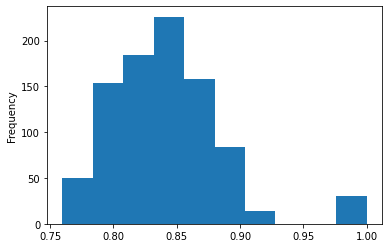

In [96]:
embedding_sims.stack().plot.hist()

In [97]:
A2 = (1-embedding_sims).stack()
A2.loc[A2<0] = 0
A2 = A2.unstack()
A2.iloc[range(len(embedding_sims)),range(len(embedding_sims))] = 0
A2

uri,d1:Affective_State.txt.json,d1:Coping_Skills.txt.json,d1:Pain_Beliefs.txt.json,d1:Personality_Traits.txt.json,d1:Psychological_Attributes.txt.json,d1:Psychological_Resources.txt.json,d2:Biomechanical_Attributes.txt.json,d2:Load.txt.json,d2:Physical_Activity.txt.json,d2:Sensorimotor_Control.txt.json,...,d5:Familial_Attributes.txt.json,d5:Genetics.txt.json,d6:Anatomy.txt.json,d6:Central_Pain_Processing.txt.json,d6:Central_Schema_Attributes.txt.json,d6:Functional_Consequence.txt.json,d6:Nociception_and_Neuropathic_Pain.txt.json,d6:Pain_Experience.txt.json,d6:Pain_Perception.txt.json,d6:Peripheral_Stimulus.txt.json
uri,,,,,,,,,,,,,,,,,,,,,
d1:Affective_State.txt.json,0.000000,0.134742,0.131409,0.089304,0.120514,0.112541,0.228466,0.208554,0.175920,0.196407,...,0.160011,0.155913,0.195011,0.151130,0.143272,0.139910,0.175484,0.109067,0.127282,0.178404
d1:Coping_Skills.txt.json,0.134742,0.000000,0.108438,0.106818,0.141341,0.086410,0.224644,0.239396,0.160314,0.196773,...,0.177933,0.190542,0.229952,0.163615,0.146952,0.154380,0.175231,0.123396,0.137229,0.209531
d1:Pain_Beliefs.txt.json,0.131409,0.108438,0.000000,0.121295,0.087918,0.127479,0.216409,0.195262,0.133661,0.172277,...,0.164531,0.141537,0.200313,0.142932,0.147678,0.102863,0.165251,0.116393,0.147896,0.145988
d1:Personality_Traits.txt.json,0.089304,0.106818,0.121295,0.000000,0.115899,0.094879,0.230688,0.230411,0.189520,0.204539,...,0.138056,0.135027,0.209049,0.130828,0.125292,0.143055,0.157141,0.113900,0.117041,0.182721
d1:Psychological_Attributes.txt.json,0.120514,0.141341,0.087918,0.115899,0.000000,0.114504,0.206526,0.185878,0.167754,0.170992,...,0.154896,0.121266,0.169468,0.142716,0.134050,0.138986,0.160575,0.124586,0.145712,0.133608
d1:Psychological_Resources.txt.json,0.112541,0.086410,0.127479,0.094879,0.114504,0.000000,0.231006,0.231626,0.179681,0.208343,...,0.164351,0.164437,0.221933,0.169181,0.155264,0.131710,0.198041,0.125029,0.138727,0.209707
d2:Biomechanical_Attributes.txt.json,0.228466,0.224644,0.216409,0.230688,0.206526,0.231006,0.000000,0.123025,0.177383,0.097744,...,0.210249,0.180143,0.119444,0.221993,0.197397,0.195065,0.211285,0.225218,0.228982,0.138514
d2:Load.txt.json,0.208554,0.239396,0.195262,0.230411,0.185878,0.231626,0.123025,0.000000,0.163292,0.128755,...,0.200660,0.148034,0.114339,0.227579,0.215488,0.199949,0.227913,0.219561,0.240235,0.130688
d2:Physical_Activity.txt.json,0.175920,0.160314,0.133661,0.189520,0.167754,0.179681,0.177383,0.163292,0.000000,0.154650,...,0.191089,0.172257,0.175840,0.182076,0.180465,0.121286,0.193269,0.152814,0.180893,0.176920


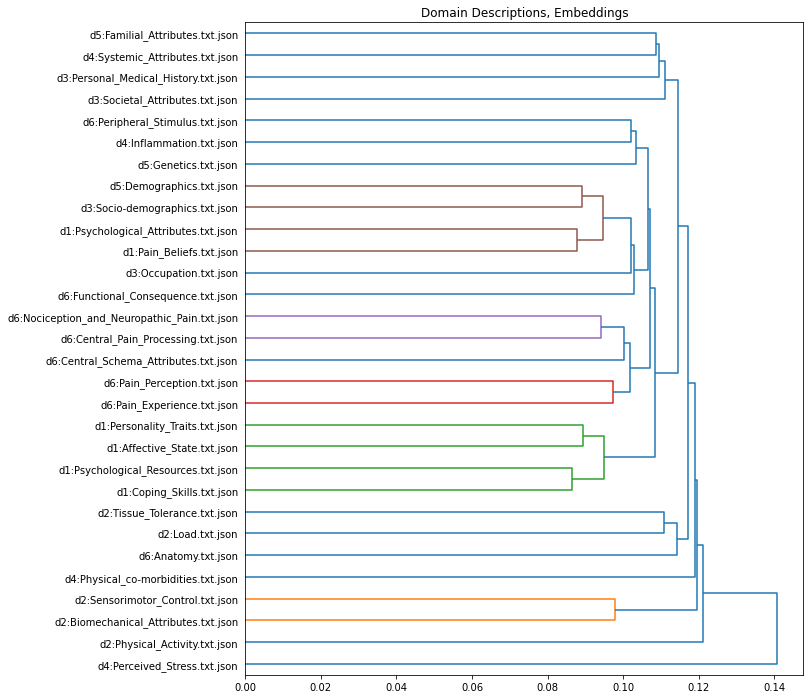

In [98]:
plt.figure(figsize=(10,12))
dists = squareform(A2)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, orientation="right",labels=embedding_sims.columns)
plt.title("Domain Descriptions, Embeddings")
plt.show()